# Assignment 5 - Expectation Maximization

## Overview

Automatic image processing is a key component to many AI systems, including facial recognition and video compression, instance segmentation of images and point cloud data. One basic method for processing is segmentation, by which we divide an image into a fixed number of components in order to simplify its representation. For example, we can train a mixture of Gaussians to represent an image, and segment it according to the simplified representation as shown in the images below.

![alt text](images/bird_color_24.png)

Or we could perform a clustering of point cloud in order to separate different objects, backgrounds etc, as shown in the image below

![alt text](images/pcd_clustered.gif)

In this assignment, you will learn to perform image compression and point cloud segmentation. To this end, you will implement Gaussian mixture models and iteratively improve their performance. First you will perform segmentation on the "Bird" (`bird_color_24.png`) and at the end run your algorithm on 3D point cloud data.

To begin, you will implement several methods of image segmentation, with increasing complexity:

1. Implement k-means clustering to segment a color image.

2. Familiarize yourself with the algorithm by running it on simple dataset.

3. Build a Gaussian mixture model to be trained with expectation-maximization.

4. Experiment with varying the details of the Gaussian mixture model’s implementation.

5. Implement and test a new metric called the Bayesian information criterion, which guarantees a more robust image segmentation.

<br>

- - -

## Part 0: Note on Vectorization

The concept of Vectorization was introduced in the last section of Assignment 4. For this assignment, please vectorize your code wherever possible using numpy arrays, instead of running for-loops over the images being processed.

For example of how this might be useful, consider the following array:
A = [12 34 1234 764 ...(has a million values)... 91, 78]

Now you need to calculate another array B, which has the same dimensions as A above. Say each value in B is calculated as follows:
(each value in B) = square_root_of(some constants pi log(k) * (each value in A))/7

You might wish to use a for-loop to compute this. However, it will take really long to run on an array of this magnitude.
Alternatively, you may choose to use numpy and perform this calculation in a single line. You can pass A as a numpy array and the entire calculation will be done in a line, resulting in B being populated with the corresponding values that come out of this formula.

Check out **Basic Operation** section of the Numpy Tutorial if you are not familiar with numpy vector/matrix operations: https://docs.scipy.org/doc/numpy-1.15.1/user/quickstart.html#basic-operations

#### Please note that numpy.vectorize DOES NOT perform vectorization, it only does a loop. 


## Part 1: K-means Clustering (19 pts)

One easy method for image segmentation is to simply cluster all similar data points together and then replace their values with the mean value. Thus, we'll warm up using k-means clustering. This will also provide a baseline to compare with your segmentation. Please note that clustering will come in handy later.

Fill out `get_initial_means()`, `k_means_step()` functions below.

In `get_initial_means()`, you should choose  k random points from the data (without replacement) to use as initial cluster means.

Your code will be unit tested automatically when you run the cell (`Cell > Run Cells OR Shift + Enter`).

#### Try to vectorize the code for it to run faster. Without vectorization it takes 25-30 minutes for the code to run.


In [13]:
%load_ext autoreload
%autoreload 2
# Run this cell and check if you have all necessary modules
from IPython.html.widgets import *
import mixture_tests as tests
import matplotlib.pyplot as plt
import os
import numpy as np
from helper_functions import *
# Please don't modify this cell

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# DON'T RUN THIS CELL IT WILL THROW AN ERROR
# IF YOU ACCIDENTALL RUN IT, IT'S OK, YOU CAN IGNORE THE ERRORS
import numpy as np
from .helper_functions import *

ModuleNotFoundError: No module named '__main__.helper_functions'; '__main__' is not a package

In [15]:
def get_initial_means(array, k):
    """
    Picks k random points from the 2D array 
    (without replacement) to use as initial 
    cluster means

    params:
    array = numpy.ndarray[numpy.ndarray[float]] - m x n | datapoints x features

    k = int

    returns:
    initial_means = numpy.ndarray[numpy.ndarray[float]]
    """

    idx_row = np.arange(array.shape[0])
    np.random.shuffle(idx_row)
    
    return array[idx_row[:k], :]
    
    
########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.K_means_test().test_initial_means(get_initial_means)
################ END OF LOCAL TEST CODE SECTION ######################

UnitTest passed successfully!


In [16]:
def k_means_step(X, k, means):
    """
    A single update/step of the K-means algorithm
    Based on a input X and current mean estimate
    calculate new means and predict clusters for each of the pixel
    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n | pixels x features (already flattened)
    k = int
    means = numpy.ndarray[numpy.ndarray[float]] - k x n

    returns:
    new_means = numpy.ndarray[numpy.ndarray[float]] - k x n
    clusters = numpy.ndarray[int] - m sized vector
    """

    # Calc the distance of all data points to each mean
    dist_all = [np.sqrt(np.sum(np.square(X - mean_i), axis=1)) for mean_i in means]
                        
    # Calc the argmin of all distances for each data point
    clusters = np.argmin(np.array(dist_all), axis=0)
    
    # Calc new means
    new_means = np.array([np.mean(X[clusters == uniq], axis=0) for uniq in np.unique(clusters)])
    
    return new_means, clusters
    

########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.K_means_test().test_k_means_step(k_means_step)
################ END OF LOCAL TEST CODE SECTION ######################

UnitTest passed successfully!


#### K-means - Visualizing the results

Now that you are done with the K-means step implementation lets try to visualize what's happening if you repeat these steps multiple times.

**You don't need to be implementing anything in the next cells until Image Segmentation Section**, but you are highly encouraged to play with parameters and datasets, to get a sense of what is happening at every algorithm iteration step.

Feel free to explore and improve the function below, it will be used for visualizing K-means progress
but it's not required and WON'T effect your grade.

In [8]:
# This cell contains a code for loading a dataset from the `data` folder
# Each of these datasets contains synthtic (generated) data
# You can simply run this cell for now and come back to it later if you want to make changes
# Make sure you implemented everything in cells above and passed the unittests
def K_means_2D_dataset(dataset_index, K):
    # Load the dataset from data folder
    X = np.loadtxt("data/%d_dataset_X.csv" % dataset_index, delimiter=",")
    print("The dataset is of a size:", X.shape)

    # Load the labels
    # Clustering is unsupervised method, where no labels are provided
    # However, since we generated the data outselves we know the clusters,
    # and load them for illustration purposes.
    y = np.int16(np.loadtxt("data/%d_dataset_y.csv" % dataset_index, delimiter=","))

    # Feel free to edit the termination condition for the K-means algorithm
    # Currently is just runs for n_iterations, before terminating
    n_iterations = 10
    m,n = X.shape
    means = get_initial_means(X,K)
    clusters = np.zeros([n])
    # keeping track of how clusters and means changed, for visualization purposes
    means_history = [means]
    clusters_history = [clusters] 
    for iteration_i in range(n_iterations):
        means, clusters = k_means_step(X, K, means)
        clusters_history.append(clusters)

    return X, y, means_history, clusters_history

# Things to try:
# - Try different initialization to see check initialization robustness
# - Improve the termination condition (you will be able to reuse later as well!)
# - Try creating you own dataset in the `data/` folder 

In [27]:
# RUN - TRY DIFFERENT PARAMETERS - REPEAT
dataset_index = 1 # for different dataset change it to number from [0,4]
K = 3 # Number of clusters - play with this number

X, y, means_history, clusters_history = K_means_2D_dataset(dataset_index, K)

# This is an interactive cell to see the progress of training your K-means algorithm.
# Feel free to improve the visualization code and share it with your classmates on Piazza
def get_cluster(i):
    clusters = clusters_history[i] # Get the clusters from K-means' i-th iteration
    plt.figure(None, figsize=(15,6)) # Set the plot size
    plt.suptitle('Drag the slider to see the algorthm training progress')
    ax1=plt.subplot(1, 2, 1)
    ax1.set_title('K-means clsuters - step %d' % i)
    for k in range(K):
        plt.plot(X[clusters==k,0], X[clusters==k,1], '.') # 
        # Try to plot the centers of the clusters 
        # You can access them by calling means_history[i]
        # How could you plot the area that belong to that cluster?

    # Just to get a flavour of how the data looks like
    ax2=plt.subplot(1, 2, 2)
    ax2.set_title('Ground truth clusters')
    for i in np.unique(y):
        ax2.plot(X[y==i,0],X[y==i,1],'.')

    plt.show()

interactive(get_cluster, i=(1,len(clusters_history)-1,1))

The dataset is of a size: (1000, 2)


interactive(children=(IntSlider(value=5, description='i', max=10, min=1), Output()), _dom_classes=('widget-int…

### Image segmentation (X Points)
2D data clustering is all cool and all but now it's time to use K-means for the image compression! 

Fill in the `k_means_segment()` function below, you will find your `k_means_step()` and `get_initial_means()` very handy here. 

You will separate the provided RGB values into k clusters using the k-means algorithm, then return an updated version of the image with the original values replaced with the corresponding cluster center values.

Your convergence test should be whether the assigned clusters stop changing. Note that this convergence test is rather slow. When no initial cluster means (`initial_means`) are provided, you need to initialize it them yourself, based on the given k.

For this part of the assignment, since clustering is best used on multidimensional data, we will be using the color image `bird_color_24.png`.

Please pay close attention to the dimensions of the data. In the `k_means_step()` you were working with m x n data, here the input is an image (`image_values`) which has a shape of **rows x columns x color_channels**.

The function should return an updated version of the image with the original values replaced with the corresponding cluster values.

In [7]:
def k_means_segment(image_values, k=3, initial_means=None):
    """
    Separate the provided RGB values into
    k separate clusters using the k-means algorithm,
    then return an updated version of the image
    with the original values replaced with
    the corresponding cluster values.

    params:
    image_values = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] - r x c x ch
    k = int
    initial_means = numpy.ndarray[numpy.ndarray[float]] or None

    returns:
    updated_image_values = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]]
    """

    # Flatten the image_value
    height, width, depth = image_values.shape
    image_values = image_values.reshape(height * width, depth)
    
    if initial_means is None:
        means = get_initial_means(image_values, k)
    else:
        means = initial_means
    
    diff_cls = 100
    clusters = np.zeros(image_values.shape[0])
    
    while diff_cls != 0: 
        clusters_prev = clusters.copy()
        means, clusters = k_means_step(image_values, k, means)
        diff_cls = np.sum(clusters_prev - clusters)
    
#     ## === My play ===
#     itr = 0
#     while itr <= iter_depth:
#         means, clusters = k_means_step(image_values, k, means)
#         itr += 1
        
    # Return updated image
    image_values_cp = image_values.copy()
    for uniq in np.unique(clusters):
        image_values_cp[clusters==uniq] = means[uniq]
    
    image_values_cp = image_values_cp.reshape(height, width, depth)
    
    return image_values_cp

    
########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.K_means_test().test_k_means(k_means_segment)
################ END OF LOCAL TEST CODE SECTION ######################

UnitTest passed successfully!


### Visulizing K-means segmentation results

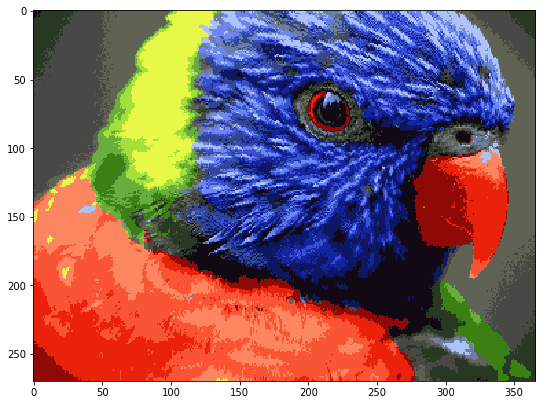

In [10]:
k=20 # number of clusters - feel free to play with it

## === My play ===
# itr_depth = 4   # my play...
# image_values = image_to_matrix('images/bird_color_24.png')
# # Play with the K value below to see the effect number of clusters have
# new_image = k_means_segment(itr_depth, image_values, k=k)

image_values = image_to_matrix('images/bird_color_24.png')
# Play with the K value below to see the effect number of clusters have
new_image = k_means_segment(image_values, k=k)

plt.figure(None,figsize=(9,12))
plt.imshow(new_image)
plt.show()


You can reuse the K-means visualization code from previous section to show the training progress on the image for different iterations and even numbers of clusters.

- - -

## Part 2: Implementing a Multivariate Gaussian Mixture Model (40 pts)

Next, we will step beyond clustering and implement a complete Gaussian mixture model.

But, before you dive into the code, you are highly encouraged to go over `read/gaussians.pdf` file before you start, to familiarize yourself with multivariate case of the Gaussian distribution.

In addition to that, there is a great ~17 minute where Alexander Ihler goes over nuts and bolds of the multivariate EM algorithm details on Youtube:
https://www.youtube.com/watch?v=qMTuMa86NzU

Another resource you can refer to is the `read/em.pdf` document attached, which is a chapter from Pattern Recognition and Machine Learning book by Christopher M. Bishop.

- - - 

Now it's time, to complete the implementation of the functions below what will later assemble into a Multivariate Gaussian Expectation Maximization algorithm:

1. Calculate the probability of a given data point (e.g. rgb value of a pixel) of belonging to a specific Gaussian component. (5 points)

2. Use expectation-maximization (EM) to train the model to represent the image as a mixture of Gaussians. (20 points)

To initialize EM, set each component's mean to the means value of randomly chosen pixels (same as for K-means) and calculate covariances based on the selected means, and set the mixing coefficients to a uniform distribution. 

We've set the convergence condition for you in `default_convergence()` (see `helper_functions.py` file): if the new likelihood is within 10% of the previous likelihood for 10 consecutive iterations, the model has converged.

**Note:** there are packages that can run EM automagically, but you have to implement your own version of EM without using these extra packages. **It also means that you are not allowed to look into any implementations of the algorithms, e.g scikit-learn and many others. NumPy is your only tool here.** 

3. Calculate the log likelihood of the trained model. (5 points)
4. Segment the image according to the trained model. (5 points)
5. Determine the best segmentation by iterating over model training and scoring, since EM isn't guaranteed to converge to the global maximum. (5 points)

It'd be helpful to implement the above functions in the following order - 
1. initialize_parameters
2. prob
3. E_step
4. M_step
5. likelihood 
6. train_model
7. cluster
8. segment
9. best_segment

We've provided comments in `mixture_models.py` to help you all along. We have also provided the necessary tests for this part in `mixture_tests.py`. Please make sure to use these tests before submitting to Bonnie.

### Warning: You may lose all marks for this part if your code runs for too long.

### You will need to vectorize your code in this part. Specifically, the method E_step() and M_step() which make up the train_model(), perform operations using numpy arrays. These are time-sensitive functions and will be called over and over as you proceed with this assignment.

For the synthetic data test which we provide to check if your training is working, the set is too small and it won't make a difference. But with the actual image that we use ahead, for-loops won't do good. Vectorized code would take under 30 seconds to converge which would typically involve about 15-20 iterations with the convergence function we have here. Inefficient code that uses loops or iterates over each pixel value sequentially, will take hours to run. You don't want to do that.

- - -

Same as in K-means you will be working with the data of size (m x n). 

In [17]:
def initialize_parameters(X, k):
    """
    Return initial values for training of the GMM
    Set component mean to a random
    pixel's value (without replacement),
    based on the mean calculate covariance matrices,
    and set each component mixing coefficient (PIs)
    to a uniform values
    (e.g. 4 components -> [0.25,0.25,0.25,0.25]).
    
    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    k = int
    
    returns:
    MU = numpy.ndarray[numpy.ndarray[float]] - k x n
    SIGMA = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] - k x n x n
    PI = numpy.ndarray[float] - k x 1 
    """
    
    row, col = X.shape
    
    # Select k random pixels as initial means 
    # shuffle the idx instead of X itself will save a copy of X!
    idx = np.arange(row)
    np.random.shuffle(idx)
    MU = X[idx[:k], :]
    
    # Calc cov matrix based on random selected means
    SIGMA = np.zeros((k, col, col))
    for k_i in range(k):
        SIGMA[k_i, :, :] = (1/row) * np.matmul((X - MU[k_i]).T, (X - MU[k_i]))
    
    # Calc PI
    PI = np.repeat(1/k, k)
    
    return MU, SIGMA, PI
    
########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.GMMTests().test_gmm_initialization(initialize_parameters)
################ END OF LOCAL TEST CODE SECTION ######################

UnitTest passed successfully!


In [18]:
def prob(x, mu, sigma):
    """Calculate the probability of a single
    data point x under component with
    the given mean and covariance.
    # NOTE: there is nothing to vectorize here yet,
    # it's a simple check to make sure you got the
    # multivariate normal distribution formula right
    # which is given by N(x;MU,SIGMA) above

    params:
    x = numpy.ndarray[float]
    mu = numpy.ndarray[float]
    sigma = numpy.ndarray[numpy.ndarray[float]]

    returns:
    probability = float
    """
    
    # Modifty this function to handle vector input of x!
    # Need to expand dim if input is a single 1*n
    if len(x.shape) == 1:
        x = np.expand_dims(x, axis=0)
    
    row, col = x.shape
    det_cov = np.linalg.det(sigma)
    norm_coef = 1 / (np.sqrt(np.power(2 * np.pi, col) * det_cov))
    
    x_mu = x - mu
    inv_cov = np.linalg.inv(sigma)
    norm_main = np.sum(np.multiply(np.dot(x_mu, inv_cov), x_mu), axis=1) # this is the vectorization (not optimal...)
    norm_exp = np.exp((-0.5) * norm_main)
    
    norm_pdf = norm_coef * norm_exp
    
    # Output has to be float if input x is 1*n, otherwise, output is vector m*n
    if row == 1:
        return norm_pdf[0]
    else:
        return norm_pdf
    
    
########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.GMMTests().test_gmm_prob(prob)
################ END OF LOCAL TEST CODE SECTION ######################

UnitTest passed successfully!


In [19]:
def E_step(X,MU,SIGMA,PI,k):
    """
    E-step - Expectation 
    Calculate responsibility for each
    of the data points, for the given 
    MU, SIGMA and PI.
    
    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    MU = numpy.ndarray[numpy.ndarray[float]] - k x n
    SIGMA = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] - k x n x n
    PI = numpy.ndarray[float] - k x 1
    k = int
    
    returns:
    responsibility = numpy.ndarray[numpy.ndarray[float]] - k x m
    """
    
    row, col = X.shape
    ri = np.zeros((k, row))
    
    # Calc Norm pdf of each datum for each cluster k
    for ki in range(k):
        ri[ki,:] = prob(X, MU[ki], SIGMA[ki])
    
    # Normalize ri using given PI
    PI = np.expand_dims(PI, axis=1)     # need to expand PI to k * 1 !
    ri = np.multiply(ri, PI)            # ri: k*m
    ri_sum = np.sum(ri, axis=0)         
    ri_sum = np.expand_dims(ri_sum, axis=0)  # must expand sum to 1*m to do np.divide later
    ri = np.divide(ri, ri_sum)
    
    return ri
    

########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.GMMTests().test_gmm_e_step(E_step)
################ END OF LOCAL TEST CODE SECTION ######################

UnitTest passed successfully!


In [20]:
def M_step(X, r, k):
    """
    M-step - Maximization
    Calculate new MU, SIGMA and PI matrices
    based on the given responsibilities.
    
    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    r = numpy.ndarray[numpy.ndarray[float]] - k x m
    k = int
    
    returns:
    new_MU = numpy.ndarray[numpy.ndarray[float]] - k x n
    new_SIGMA = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] - k x n x n
    new_PI = numpy.ndarray[float] - k x 1
    """

    row, col = X.shape
    
    # Cacl total resp for each cluster k (k*1)
    tot_r = np.sum(r, axis=1)
    tot_r = np.expand_dims(tot_r, axis=1)    # need to expand dim on column (k,) --> (k,1)

    
    # Update MU - k*n
    X_rwt = np.dot(r, X)   # k*n
    new_MU = np.divide(X_rwt, tot_r)
    
    
    # [Vectorization method]Update SIGMA use new_MU
    # First reshape matrices to fit the vectorization
    new_MU = np.expand_dims(new_MU, axis=1)         # (k*n) --> (k*1*n)
    X_tmp = np.tile(X, (k,1)).reshape(k, row, col)  # (m*n) --> (k*m*n)   * don't modify X!
    r = np.expand_dims(r, axis=2)                   # (k*1) --> (k*1*1)
    tot_r = tot_r.reshape(k, 1, 1)                  # (k*1) --> (k*1*1)
    
    # Let's show the middle steps, but commented for faster speed (should use X_tmp below...)
    # X1 = X - new_MU
    # X2 = np.multiply(X1, r)     # element-wise multiply on each layer k: r * (X - new_MU) is done
    # X3 = np.transpose(X2, axes=(0,2,1))   # transpose centain axes! (k*m*n) --> (k*n*m)
    # X4 = np.matmul(X3, X1)      # must use np.matmul(), np.dot() won't work. (k*n*m) * (k*m*n) --> (k*n*n)
    # new_SIGMA = (1/tot_r) * X4  # assign weight on each layer k
    
    new_SIGMA = (1/tot_r) * \
                np.matmul(np.transpose(np.multiply(r, (X_tmp - new_MU)), axes=(0,2,1)),
                          (X_tmp - new_MU))
    
    # [No vectorization method]Update SIGMA use new_MU
    # new_SIGMA = np.zeros((k, col, col))
    # for ki in range(k):
    #     r_ki = np.expand_dims(r[ki], axis=1)

    #     # Update the data X using the r
    #     Xtmp = X.copy()
    #     Xtmp = Xtmp - new_MU[ki]

    #     # Update the k-th Cov
    #     new_SIGMA[ki, :, :] = np.dot(np.multiply(Xtmp, r_ki).T, Xtmp) * (1/tot_r[ki])
        
        
    # Update PI
    new_PI = tot_r * (1/row)
    
    
    # Reshape back for output
    new_MU = new_MU.reshape(k, col)
    new_PI = new_PI.reshape(k,)    # need to reshape back (k,1,1) --> (k,)    
    
    return new_MU, new_SIGMA, new_PI
    
########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.GMMTests().test_gmm_m_step(M_step)
################ END OF LOCAL TEST CODE SECTION ######################

UnitTest passed successfully!


In [21]:
def likelihood(X, PI, MU, SIGMA, k):
    """Calculate a log likelihood to the 
    trained model based on the following
    formula for posterior probability:
    log10(Pr(X | mixing, mean, stdev)) = sum((n=1 to N), log10(sum((k=1 to K),
                                      mixing_k * N(x_n | mean_k,stdev_k))))

    Make sure you are using log base 10, instead of log base 2.
    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    MU = numpy.ndarray[numpy.ndarray[float]] - k x n
    SIGMA = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] - k x n x n
    PI = numpy.ndarray[float] - k x 1
    k = int

    returns:
    log_likelihood = int
    """
    
    row, col = X.shape
    likelihood = np.zeros((k, row))
    for ki in range(k):
        likelihood[ki, :] = PI[ki] * prob(X, MU[ki], SIGMA[ki])
        
    # Take log of the sum(likelihood)
    # middle step : 
    # np.sum(likelihood, axis=0))   # (1*m)
    log_likelihood = np.sum(np.log10(np.sum(likelihood, axis=0)))
    
    return log_likelihood
    
########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.GMMTests().test_gmm_likelihood(likelihood)
################ END OF LOCAL TEST CODE SECTION ######################

UnitTest passed successfully!


In [22]:
def train_model(X, k, convergence_function, initial_values = None):
    """
    Train the mixture model using the 
    expectation-maximization algorithm. 
    Which is an interative execution of
    the E and M steps from above.
    If the initial_values aer None, initialize them.
    Else it's a tuple of the format (MU, SIGMA, PI).
    Convergence is reached when convergence_function
    returns terminate as True,
    see default convergence_function example 
    in `helper_functions.py`

    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    k = int
    convergence_function = func
    initial_values = None or (MU, SIGMA, PI)

    params:
    returns:
    new_MU = numpy.ndarray[numpy.ndarray[float]] - k x n
    new_SIGMA = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] - k x n x n
    new_PI = numpy.ndarray[float] - k x 1
    responsibility = numpy.ndarray[numpy.ndarray[float]] - k x m
    """

    if initial_values is None:
        initial_values = initialize_parameters(X, k)
    
    MU, SIGMA, PI = initial_values
    loglike  = 0
    conv_ctr = 0
    tf_conv  = False
    
    while (tf_conv==False):
        #print('Converge counter: ', conv_ctr)
        loglike_pre = loglike
        r = E_step(X, MU, SIGMA, PI, k)
        MU, SIGMA, PI = M_step(X, r, k)
        loglike = likelihood(X, PI, MU, SIGMA, k)
        
        conv_ctr, tf_conv = convergence_function(loglike_pre, loglike, conv_ctr)
        
    return MU, SIGMA, PI, r
    
########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.GMMTests().test_gmm_train(train_model, likelihood)
################ END OF LOCAL TEST CODE SECTION ######################

UnitTest passed successfully!


In [23]:
def cluster(r):
    """
    Based on a given responsibilities matrix
    return an array of clusters.
    Assign each datapoint to a cluster based,
    on component with a max-likelihood 
    (maximum responsibility value).
    
    params:
    r = numpy.ndarray[numpy.ndarray[float]] - k x m - responsibility matrix
    
    return:
    clusters = numpy.ndarray[int] - m x 1 
    """

    return np.argmax(r, axis=0)
    
########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.GMMTests().test_gmm_cluster(cluster)
################ END OF LOCAL TEST CODE SECTION ######################

UnitTest passed successfully!


In [24]:
def segment(X, MU, k, r):
    """
    Segment the X matrix into the pre-specified
    number of components. Returns the matrix with 
    the each data point replace with its max-likelihood
    component mean. E.g in case of image returns 
    the original matrix with the each pixel's 
    intensity replaced with its max-likelihood
    component mean. (the shape is still mxn,
    not original image size)

    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    MU = numpy.ndarray[numpy.ndarray[float]] - k x n
    k = int
    r = numpy.ndarray[numpy.ndarray[float]] - k x m - responsibility matrix

    returns:
    new_X = numpy.ndarray[numpy.ndarray[float]] - m x n
    """

    clstr = cluster(r)    # m*1
    new_X = X.copy()
    for ki in range(k):
        new_X[clstr==ki,:] = MU[ki]
    
    return new_X
    
########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.GMMTests().test_gmm_segment(train_model, segment)
################ END OF LOCAL TEST CODE SECTION ######################

UnitTest passed successfully!


In [73]:
def best_segment(X,k,iters):
    """Determine the best segmentation
    of the image by repeatedly
    training the model and
    calculating its likelihood.
    Return the segment with the
    highest likelihood.

    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    k = int
    iters = int

    returns:
    likelihood = float
    segment = numpy.ndarray[numpy.ndarray[float]]
    """
    
    likelihood_max = -np.inf
    segment_bst = X.copy()
    i = 0
    
    while i<=iters:
        # Keep training the model (random initialize)
        MU, SIGMA, PI, r = train_model(X, k, 
                                       convergence_function = default_convergence, 
                                       initial_values = None)
        
        # Segment the X using the training results
        Xnew = segment(X, MU, k, r)
        likelihood_tmp = likelihood(Xnew, PI, MU, SIGMA, k)
        
        # Update the best segment
        if likelihood_tmp > likelihood_max:
            likelihood_max = likelihood_tmp
            # segment_bst = Xnew.copy()
            segment_bst = Xnew  # let's see what if we don't give a copy
        
        i += 1
    
    
    return likelihood_max, segment_bst
    
########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.GMMTests().test_gmm_best_segment(best_segment)
################ END OF LOCAL TEST CODE SECTION ######################

UnitTest passed successfully!


#### GMM - Visualizing the results

Now that you are done with the EM implementation lets try to visualize what's happening if you repeat these steps multiple times.

**You don't need to be implementing anything in the next 2 cells, but you are highly encouraged to play with parameters and datasets, to get a visual sense of what is happening at every step.


Feel free to explore and improve the function below, it will be used for visualizing K-means progress
but it's not required and WON'T effect your grade.

In [77]:
def GMM_2D_dataset(dataset_index, K):
    # Load the dataset from data folder
    X = np.loadtxt("data/%d_dataset_X.csv" % dataset_index, delimiter=",")
    print("There are %d datapoints in the current dataset, each of a size %d" % X.shape)
    # Load the labels
    # Clustering is unsupervised method, where no labels are provided
    # However, since we generated the data outselves we know the labels,
    # and load them for illustration purposes.
    y = np.int16(np.loadtxt("data/%d_dataset_y.csv" % dataset_index, delimiter=","))
    # Feel free to edit the termination condition for the EM algorithm
    # Currently is just runs for n_iterations, before terminating
    
    MU, SIGMA, PI = initialize_parameters(X, K)
    
    clusters_history = []
    for _ in range(200):
        r = E_step(X,MU,SIGMA,PI,K)
        new_MU, new_SIGMA, new_PI = M_step(X, r, K)
        PI, MU, SIGMA = new_PI, new_MU, new_SIGMA
        clusters = cluster(r)
        clusters_history.append(clusters)

    return X, y, clusters_history

In [78]:
# TRY DIFFERENT PARAMETERS
dataset_index = 4 # for different dataset change it to number from [0,5]
K = 3 # Number of clusters - play with this number

X, y, clusters_history = GMM_2D_dataset(dataset_index, K)

# This is an interactive cell to see the progress of training your GMM algorithm.
# Feel free to improve the visualization code and share it with your classmates on Piazza.
def get_cluster(i):
    clusters = clusters_history[i] # Get the clusters from K-means' i-th iteration
    plt.figure(None, figsize=(15,6)) # Set the plot size
    plt.suptitle('Drag the slider to see the algorthm training progress')
    ax1=plt.subplot(1, 2, 1)
    ax1.set_title('K-means clsuters - step %d' % i)
    for k in range(K):
        plt.plot(X[clusters==k,0], X[clusters==k,1], '.') # 
        # Try to plot the centers of the clusters 
        # You can access them by calling means_history[i]
        # How could you plot the area that belong to that cluster?

    # Just to get a flavour of how the data looks like
    ax2=plt.subplot(1, 2, 2)
    ax2.set_title('Ground truth clusters')
    for i in np.unique(y):
        ax2.plot(X[y==i,0],X[y==i,1],'.')

    plt.show()

interactive(get_cluster, i=(0,len(clusters_history)-1,1))

There are 1000 datapoints in the current dataset, each of a size 2


interactive(children=(IntSlider(value=99, description='i', max=199), Output()), _dom_classes=('widget-interact…

### Let's visualize the image compression results of GMM.

In [11]:
# import time

image_file = 'images/bird_color_24.png' # Image path
original_image_matrix = image_to_matrix(image_file) # Save original image
image_matrix = original_image_matrix.reshape(-1,3) # collapse the dimension
K = 5 # K

# start = time.time()
_, best_seg = best_segment(image_matrix, K, iters = 10)
# end = time.time()
# print('Time collapes: ', (end-start))

new_image = best_seg.reshape(*original_image_matrix.shape) # reshape collapsed matrix to original size
# Show the image
plt.figure(None,figsize=(9,12))
plt.imshow(new_image)
plt.show()

NameError: name 'best_segment' is not defined

---

## Part 3: Model Experimentation (20 pts)

We'll now experiment with a few methods for improving GMM performance.

## Part 3a: Improved Initialization 

12.5 points

To run EM in our baseline Gaussian mixture model, we use random initialization to determine the initial values for our component means. We can do better than this!

Fill in `improved_initialization()` with an improvement in component initialization. Please don't use any external packages for anything other than basic calculations. Note that your improvement might significantly slow down runtime, although we don't expect you to spend more than 10 minutes on initialization.

Hint: you'll probably want an unsupervised learning method to initialize your component means. Clustering is one useful example of unsupervised learning.

In [31]:
def improved_initialization(X,k):
    """
    Initialize the training
    process by setting each
    component mean using some algorithm that
    you think might give better means to start with,
    based on the mean calculate covariance matrices,
    and set each component mixing coefficient (PIs)
    to a uniform values
    (e.g. 4 components -> [0.25,0.25,0.25,0.25]).
    
    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    k = int
    
    returns:
    MU = numpy.ndarray[numpy.ndarray[float]] - k x n
    SIGMA = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] - k x n x n
    PI = numpy.ndarray[float] - k x 1 
    """

    # First pick random means to start with
    row, col = X.shape
    idx = np.arange(row)
    np.random.shuffle(idx)
    
    MU = X[idx[:k], :]
    PI = np.repeat(1/k, k)
    
    # Run K-means itr times and calc loglikelihood each time
    likelihood_max = -np.inf
    MU_best = MU.copy()
    SIGMA_best = np.zeros((k, col, col))
    
    i = 0
    itr = 20
    while i <= itr:
        # Update means
        MU, _ = k_means_step(X, k, MU)
        
        # Calc sigma
        MU = np.expand_dims(MU, axis=1)    # (k*n) --> (k*1*n)
        SIGMA = (1/row) * np.matmul(np.transpose((np.tile(X, (k,1)).reshape(k, row, col) - MU), axes=(0,2,1)), 
                                    (np.tile(X, (k,1)).reshape(k, row, col) - MU))     # (m*n) --> (k*m*n)
        likelihood_tmp = likelihood(X, PI, MU, SIGMA, k)
        
        # Pick the one with highest likelihood
        if likelihood_tmp > likelihood_max:
            likelihood_max = likelihood_tmp
            MU_best = MU.reshape(k, col).copy()
            SIGMA_best = SIGMA.copy()
        
        i += 1
    
    
    return MU_best, SIGMA_best, PI
    
########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.GMMTests().test_gmm_improvement(improved_initialization, initialize_parameters, train_model, likelihood)
################ END OF LOCAL TEST CODE SECTION ######################

improved_likelihood:  65666.62963381904
UnitTest passed successfully!


## Part 3b: Convergence Condition

7.5 points

You might be skeptical of the convergence criterion we've provided in `default_convergence()`. To test out another convergence condition, implement `new_convergence_condition()` to return true if all the new model parameters (means, variances, and mixing coefficients) are within 10% of the previous variables for 10 consecutive iterations. This will mean re-implementing `train_model()`, which you will also do in `train_model_improved()` function.

In [43]:
def new_convergence_function(previous_variables, new_variables, conv_ctr,
                             conv_ctr_cap=10):
    """
    Convergence function
    based on parameters:
    when all variables vary by
    less than 10% from the previous
    iteration's variables, increase
    the convergence counter.

    params:

    previous_variables = [numpy.ndarray[float]]
                         containing [means, variances, mixing_coefficients]
    new_variables = [numpy.ndarray[float]]
                    containing [means, variances, mixing_coefficients]
    conv_ctr = int
    conv_ctr_cap = int

    return:
    conv_ctr = int
    converged = boolean
    """

    # Calc each param %age change use element-wise calculation
    tf_cov_all = []
    for para_i in range(len(previous_variables)):
        chg_tmp = abs(np.divide(np.subtract(new_variables[para_i], previous_variables[para_i]), 
                                previous_variables[para_i]))
        tf_cov_parai = np.max(chg_tmp) <= 0.05
        tf_cov_all.append(tf_cov_parai)
    
    # Make sure all para %age change is <= 5% for 10 consecutive times...
    if np.all(tf_cov_all):
        conv_ctr += 1
    else:
        conv_ctr = 0
    
    return conv_ctr, conv_ctr > conv_ctr_cap
    
    
def train_model_improved(X, k, convergence_function, initial_values = None):
    """
    Train the mixture model using the 
    expectation-maximization algorithm. 
    Which is an interative execution of
    the E and M steps from above.
    Convergence is reached when convergence_function
    returns terminate as True,
    see default convergence_function example 
    in `helper_functions.py`

    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    k = int
    convergence_function = func
    initial_values = None or (MU, SIGMA, PI)

    params:
    returns:
    new_MU = numpy.ndarray[numpy.ndarray[float]] - k x n
    new_SIGMA = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] - k x n x n
    new_PI = numpy.ndarray[float] - k x 1
    responsibility = numpy.ndarray[numpy.ndarray[float]] - k x m
    """
    # This is single new_convergence_function condition: 
#     if initial_values is None:
#         initial_values = improved_initialization(X, k)
    
#     MU, SIGMA, PI = initial_values
#     para = [MU, SIGMA, PI]
#     #loglike  = 0
#     conv_ctr = 0
#     tf_conv  = False
    
#     while (tf_conv==False):
#         #print('Converge counter: ', conv_ctr)
#         #loglike_pre = loglike
#         para_pre = para.copy()
#         r = E_step(X, MU, SIGMA, PI, k)
#         MU, SIGMA, PI = M_step(X, r, k)
#         para = [MU, SIGMA, PI]
#         #loglike = likelihood(X, PI, MU, SIGMA, k)
        
#         conv_ctr, tf_conv = new_convergence_function(para_pre, para, conv_ctr)
        
#     return MU, SIGMA, PI, r    
    
    
    # Following applies both new_convergence_function & default_convergence (both para chg and loglikelihood chg)
    if initial_values is None:
        initial_values = improved_initialization(X, k)
    
    MU, SIGMA, PI = initial_values
    para = [MU, SIGMA, PI]
    loglike  = 0
    conv_ctr     = 0
    conv_ctr_new = 0
    tf_conv     = False
    tf_conv_new = False
    
    while (tf_conv==False) or (tf_conv_new==False):
        #print('Converge counter: ', conv_ctr)
        loglike_pre = loglike
        para_pre = para.copy()
        
        r = E_step(X, MU, SIGMA, PI, k)
        MU, SIGMA, PI = M_step(X, r, k)
        
        para = [MU, SIGMA, PI]
        loglike = likelihood(X, PI, MU, SIGMA, k)
        
        conv_ctr_new, tf_conv_new = new_convergence_function(para_pre, para, conv_ctr_new)
        conv_ctr, tf_conv = default_convergence(loglike_pre, loglike, conv_ctr)
        
    return MU, SIGMA, PI, r
    
    
########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
# Unittest below will check both of the functions at the same time. 
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.GMMTests().test_convergence_condition(improved_initialization, train_model_improved, initialize_parameters, train_model, likelihood, new_convergence_function)
################ END OF LOCAL TEST CODE SECTION ######################

UnitTest passed successfully!


## Part 4: Bayesian Information Criterion (20 pts)

In our previous solutions, our only criterion for choosing a model was whether it maximizes the posterior likelihood regardless of how many parameters this requires. As a result, the "best" model may simply be the model with the most parameters, which would be overfit to the training data.

To avoid overfitting, we can use the [Bayesian information criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) (a.k.a. BIC) which penalizes models based on the number of parameters they use. In the case of the Gaussian mixture model, this is equal to the number of components times the number of variables per component (mean, variance and mixing coefficient).

## Part 4a: Implement BIC

5 points

Implement `bayes_info_criterion()` to calculate the BIC of a trained Gaussian Mixture Model (based on the given parameters).


In [35]:
def bayes_info_criterion(X, PI, MU, SIGMA, k):
    """
    See description above
    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n
    MU = numpy.ndarray[numpy.ndarray[float]] - k x n
    SIGMA = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] - k x n x n
    PI = numpy.ndarray[float] - k x 1
    k = int
    
    return:
    bayes_info_criterion = int
    """
    
    # Calculate number of para
    row, col = X.shape
    num_PI = 1
    num_SIGMA = col * col
    num_MU = col
    num_para = k * (num_PI + num_SIGMA + num_MU)
    
    # Calc loglikelihood
    log_like = likelihood(X, PI, MU, SIGMA, k)
    BIC = np.log10(row) * num_para - 2 * log_like
    
    return BIC
    
    
########## DON'T WRITE ANY CODE OUTSIDE THE FUNCTION! ################
##### CODE BELOW IS USED FOR RUNNING LOCAL TEST DON'T MODIFY IT ######
tests.GMMTests().test_bayes_info(bayes_info_criterion)
################ END OF LOCAL TEST CODE SECTION ######################

UnitTest passed successfully!


## Part 4b: Test BIC

15 points

Now implement `BIC_likelihood_model_test()`, in which you will use the BIC and likelihood to determine the optimal number of components in the `bird_color_24` image. Use the `train_model()` or `train_model_improved()`, iterate from k=2 to k=7 (k - # of clusters) and use the provided means to train a model that minimizes its BIC and a model that maximizes its likelihood.
Then, fill out `BIC_likelihood_question()` to return the number of components in both the min-BIC and the max-likelihood model.

In [37]:
def BIC_likelihood_model_test():
    """Test to compare the
    models with the lowest BIC
    and the highest likelihood.

    returns:
    n_comp_min_bic = int
    n_comp_max_likelihood = int

    """
    comp_means = [
        np.array([[0.67644833, 0.63705593, 0.34151605],
               [0.82106333, 0.803725  , 0.38302438]]),
        np.array([[0.67644833, 0.63705593, 0.34151605],
               [0.82106333, 0.803725  , 0.38302438],
               [0.48719558, 0.43396747, 0.57330976]]),
        np.array([[0.67644833, 0.63705593, 0.34151605],
               [0.82106333, 0.803725  , 0.38302438],
               [0.48719558, 0.43396747, 0.57330976],
               [0.37512508, 0.7997302 , 0.64795305]]),
        np.array([[0.67644833, 0.63705593, 0.34151605],
               [0.82106333, 0.803725  , 0.38302438],
               [0.48719558, 0.43396747, 0.57330976],
               [0.37512508, 0.7997302 , 0.64795305],
               [0.14751079, 0.351123  , 0.75471674]]),
        np.array([[0.67644833, 0.63705593, 0.34151605],
               [0.82106333, 0.803725  , 0.38302438],
               [0.48719558, 0.43396747, 0.57330976],
               [0.37512508, 0.7997302 , 0.64795305],
               [0.14751079, 0.351123  , 0.75471674],
               [0.56489468, 0.87895182, 0.25817842]]),
        np.array([[0.67644833, 0.63705593, 0.34151605],
               [0.82106333, 0.803725  , 0.38302438],
               [0.48719558, 0.43396747, 0.57330976],
               [0.37512508, 0.7997302 , 0.64795305],
               [0.14751079, 0.351123  , 0.75471674],
               [0.56489468, 0.87895182, 0.25817842],
               [0.08769436, 0.80069854, 0.50162118]])
        ]
    
    image_file = 'images/bird_color_24.png'
    X = image_to_matrix(image_file).reshape(-1, 3)
    row, col = X.shape
    
    # Initialize for two models
    bic_min = np.inf
    k_minbic = 0
    
    loglike_max = -np.inf
    k_maxlike = 0
    
    for Mu in comp_means:
        # Calc all para using the given mean
        k = Mu.shape[0]
        Mu_tmp = np.expand_dims(Mu, axis=1)    # (k*n) --> (k*1*n)
        Sigma = (1/row) * np.matmul(np.transpose((np.tile(X, (k,1)).reshape(k, row, col) - Mu_tmp), axes=(0,2,1)), 
                                    (np.tile(X, (k,1)).reshape(k, row, col) - Mu_tmp))     # (m*n) --> (k*m*n)
        Pi = np.repeat(1/k, k)
        initial_values = (Mu, Sigma, Pi)
        
        # Train the model
        Mu, Sigma, Pi, r = train_model_improved(X, k, new_convergence_function, initial_values)
        
        # Calc BIC
        bic_tmp = bayes_info_criterion(X, Pi, Mu, Sigma, k)
        
        # Calc likelihood
        loglike_tmp = likelihood(X, Pi, Mu, Sigma, k)
        
        if bic_tmp < bic_min:
            bic_min = bic_tmp
            k_minbic = k
            
        if loglike_tmp > loglike_max:
            loglike_max = loglike_tmp
            k_maxlike = k
    
    return k_minbic, k_maxlike
    


In [41]:
# Feel free to use this cell to run your implementation

# let's run the BIC test for 5 times
# i = 0
# while i<=5:
#     k_minbic, k_maxlike = BIC_likelihood_model_test()
#     print('k_minbic:', k_minbic,'k_maxlike', k_maxlike)
#     i+=1

k_minbic, k_maxlike = BIC_likelihood_model_test()
# print('k_minbic:', k_minbic,'k_maxlike', k_maxlike)



k_minbic: 7 k_maxlike 7


In [39]:
def BIC_likelihood_question():
    """
    Choose the best number of
    components for each metric
    (min BIC and maximum likelihood).

    returns:
    pairs = dict
    """
    bic = 7
    likelihood = 7
    pairs = {
        'BIC': bic,
        'likelihood': likelihood
    }
    return pairs

## Part 5: Return your name

1 point

A simple task to wind down the assignment. Return your name from the function aptly called `return_your_name()`.


In [ ]:
def return_your_name():
    # return your name
    # TODO: finish this
    return 'Yuchen An'


## Part 6: Bonus

+5 points

#### Bonus points are added to the grade for this assignment, not to your overall grade.

A crucial part of machine learning is working with very large datasets. As stated before, using for loops over these datasets will result in the code taking many hours, or even several days, to run. Even vectorization can take time if not done properly, and as such there are certain tricks you can perform to get your code to run as fast as physically possible.

For this part of the assignment, you will need to implement part of a k-Means algorithm. You are given two arrays - points_array with X n-dimensional points, and means_array with Y n-dimensional points. You will need to return an X x Y array containing the distances from each point in points_array to each point in means_array.

Your code will be tested using two very large arrays, against our reference implementation.

If your implementation returns the correct answer in time comparable to our implementation, you will receive 5 bonus points on this assignment.

For reference, the data used is in the order of thousands of points and hundreds of means, and Bonnie automatically kills a grading script that takes more than 250MB. So please test accordingly locally before submitting, as you may lose a submission for an inefficient solution. It is very likely that you could run out of memory if your implementation is inefficient.


You're done with the requirements! Hope you have completed the functions in the `mixture_models.py` file and tested everything using `mixture_tests.py`.


In [ ]:
def bonus(points_array, means_array):
    """
    Return the distance from every point in points_array
    to every point in means_array.

    returns:
    dists = numpy array of float
    """
    # TODO: fill in the bonus function
    # REMOVE THE LINE BELOW IF ATTEMPTING BONUS
    raise NotImplementedError()
    return dists

# There are no local test for thus question, fill free to create them yourself.
# Feel free to play with it in a separate python file, and then just copy over 
# your implementation before the submission.

---

## Congrats, you are done with the part of the assignment which is graded
### Please follow the instructions in the README to submit your code for grading.

- - -


Next is as promised segmentation of the Point Cloud data. 

In order to run the code below you first need to install an `open3d` library. If you used `pip install -r requirements.txt` command for this assignment, it should already be installed. Else, you can install it `pip install open3d-python` command, if you used virtual environment, make sure to activate it before running the code.

You can also refer to official Open3d documentation http://www.open3d.org/docs/getting_started.html for details about the installation and library itself.

RGBD (**RGB** + **D**epth) data is usually stored as two separated images, one contains RGB (color) information and second one contains only depth, thus is a grayscale image. Let's load a data sample visualize it.

In [ ]:
from open3d import * 

In [ ]:
# Function below load the data
def load_rgbd_image(image_path, depth_path):
    color_raw = read_image(image_path)
    depth_raw = read_image(depth_path)
    #  details about function http://www.open3d.org/docs/tutorial/Basic/rgbd_odometry.html
    # We are using a data sample from the SUN RGB-D (http://rgbd.cs.princeton.edu/) dataset
    return color_raw, depth_raw

# We can plot these images separately using the function below
def plot_rgbd(color_image, depth_image):
    plt.figure(None,(15,15))
    plt.subplot(1, 3, 1)
    plt.title('Color image')
    plt.imshow(color_image)
    plt.subplot(1, 3, 2)
    plt.title('SUN depth image')
    plt.imshow(depth_image)
    plt.show()

In [ ]:
import glob
rgbd_dataset = glob.glob('rgbd/image/*.jpg') # TODO fix it
image_number = 3 # [0,4] there are five different images in the folder

image_file = rgbd_dataset[image_number]
depth_file = image_file.replace('image','depth')[:-4] + '.png'
assert os.path.isfile(image_file); 
assert os.path.isfile(depth_file);
color_image, depth_image = load_rgbd_image(image_file, depth_file)
plot_rgbd(color_image, depth_image)

In [ ]:
# Next we can convert the depth image into a point cloud 
def show_point_cloud(color_raw, depth_raw):
    rgbd_image = create_rgbd_image_from_sun_format(color_raw, depth_raw);
    pcd = create_point_cloud_from_rgbd_image(rgbd_image, 
                 PinholeCameraIntrinsic(PinholeCameraIntrinsicParameters.PrimeSenseDefault))
    # Flip it, otherwise the pointcloud will be upside down
    pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
    draw_geometries([pcd])
    return pcd

In [ ]:
pcd = show_point_cloud(color_image, depth_image)

In [ ]:
# Lets have a look at the structure of the point cloud data
pcd_points = np.asarray(pcd.points)
print("Point cloud data - shape:", pcd_points.shape)

Point cloud data is represented as an unsorted set of the size M x N., where M is the number of points and N is the x,y,z value for each point. If you are interested you can access the color data in `pcd.colors`.

Let us try to perform a segmentation on the image we just loaded.

In [ ]:
# Setting the number of clusters
K = 5
# Note: it's just a simple train model run
# To improve it you can adapt the best_segment() 
# to generate the clusters with the best model
initial_params = initialize_parameters(pcd_points, K)
MU, SIGMA, PI, r = train_model(pcd_points, K,
                               convergence_function=default_convergence,
                               initial_values=initial_params)
clusters = cluster(r)

In [ ]:
# Generate a set of size K of distinct color to plot the clusters
# Adapted from https://stackoverflow.com/questions/876853/generating-color-ranges-in-python
import colorsys
HSV_tuples = [(x*1.0/K, 1.0, 1.0) for x in range(K)]
color_maps = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))

### Visualizing the segmented point cloud data!

In [ ]:
or_pcd = PointCloud() # Create new point cloud handler
or_pcd.points = Vector3dVector(pcd_points) # set point cloud data
colors = np.zeros_like(pcd_points) # initialize colors to 0
for i, point in enumerate(np.unique(clusters)):
    random_color = color_maps[i]
    cluster_mask = (clusters == point) # get the mask of the cluster i
    colors[cluster_mask,:] = random_color # set random color to all the point of this segment
or_pcd.colors = Vector3dVector(colors) # set color data
draw_geometries([or_pcd]) # visualize point cloud

Some questions to think about:
- Would adding a color help or harm the segmentation results?
- How about the case: segment RGB data -> add depth -> convert to Point Cloud -> cluster? Would that help/harm?
- Could you think of a way you could compress the point cloud data?

Things to try:
- Segmentation here is done in purely unsupervised manner, you could manually combine multiple gaussian
- How about merging multiple scenes into a single one? You could crop one segment from one scene and place it inside another scene.
- Try K-means on point cloud data and see what results does it produces
- Can we omit the step of conversion to point cloud? And use depth only? Or depth with x,y coordinates?

### ~END~